In [1]:
from pendulum_forces import MagneticPendulumInvSpherical, MagneticPendulumXY
import numpy as np
import sympy as sp
from scipy.constants import g as g_value
from scipy.integrate import solve_ivp
from scipy.cluster.vq import kmeans2
from matplotlib import pyplot as plt
%matplotlib widget

In [2]:
P = MagneticPendulumInvSpherical(4)
# P = MagneticPendulumXY(4)

const1_subs = {
    'm': 1,
    'g': g_value,
    'L': g_value,
    'R': 2,
    'h': 0.5,
    'b': 0.1,   
}
magnet_strength = 10

magnet_polarity_vals = dict((p.name, magnet_strength) for p in P.polarity_list)
constant_subs = const1_subs | magnet_polarity_vals

bob = P.create_bob(constant_subs=constant_subs)

In [3]:
t_max = 500
dt = 0.001

## specifically for spherical
to_x = lambda r,θ,ϕ: r*np.sin(θ)*np.cos(ϕ)
to_y = lambda r,θ,ϕ: r*np.sin(θ)*np.sin(ϕ)
to_z = lambda r,θ,ϕ: -r*np.cos(θ)
to_cartesian = lambda r,θ,ϕ: [to_x(r,θ,ϕ), to_y(r,θ,ϕ), to_z(r,θ,ϕ)]

ddt = P._get_ddt(bob=bob)


In [4]:
# setup
resolution=1000

phi_min = 0
phi_max = 2*np.pi
theta_min = 0
theta_max = np.pi/4

## go
theta_resolution = int(resolution*abs(theta_max-theta_min)/(np.pi))
print(theta_resolution)
r_const = constant_subs['L']
phi = np.linspace(phi_min, phi_max, resolution, endpoint=False)
theta = np.linspace(theta_min, theta_max, theta_resolution, endpoint=False)

starting_θ_ϕ_pairs = np.array(np.meshgrid(theta, phi)).T.reshape(-1,2)
starting_θ_ϕ_pairs.shape


249


(249000, 2)

In [5]:
from tqdm.notebook import tqdm
t_max = 100
dt = 0.001
t_vals = np.arange(0, t_max, dt)

In [6]:
final_positions_array = np.empty_like(starting_θ_ϕ_pairs)
np_eps = np.finfo(np.float64).eps

t_vals = np.arange(0, t_max, dt)

for i, (θ_start, ϕ_start) in enumerate(starting_θ_ϕ_pairs):
    
    if abs(θ_start % np.pi) <= np_eps:
        if θ_start == 0:
            θ_start = np_eps
        else:
            θ_start -= 10*np_eps

    starting_pos = np.array([r_const, θ_start, ϕ_start, 0,0,0])
    final_positions_array[i] = solve_ivp(ddt, (0, t_max), starting_pos, t_eval=t_vals, method='RK45').y[1:3, -1]    

KeyboardInterrupt: 

In [7]:
i

217549

In [8]:
final_positions_array.shape

(249000, 2)

In [9]:
def col_map(x):
    if x == 0:
        return "lime"
    if x == 1:
        return 'red'
    if x == 2:
        return 'blue'
    if x == 3:
        return 'yellow'
    else:
        return 'black'

In [10]:
magnet_positions = []
for magnet_pos in P.magnet_positions_C:
    magnet_pos = magnet_pos.subs(constant_subs)
    magnet_positions.append([magnet_pos.dot(P.coordsystem.C.i), magnet_pos.dot(P.coordsystem.C.j), magnet_pos.dot(P.coordsystem.C.k)])
magnet_positions

equilibria_regions = np.array(magnet_positions + [[0,0,magnet_positions[0][2]]], dtype=np.float64)
equilibria_regions

array([[  2.     ,   0.     , -10.30665],
       [  0.     ,   2.     , -10.30665],
       [ -2.     ,   0.     , -10.30665],
       [  0.     ,  -2.     , -10.30665],
       [  0.     ,   0.     , -10.30665]])

(-9.80665, 9.80665)

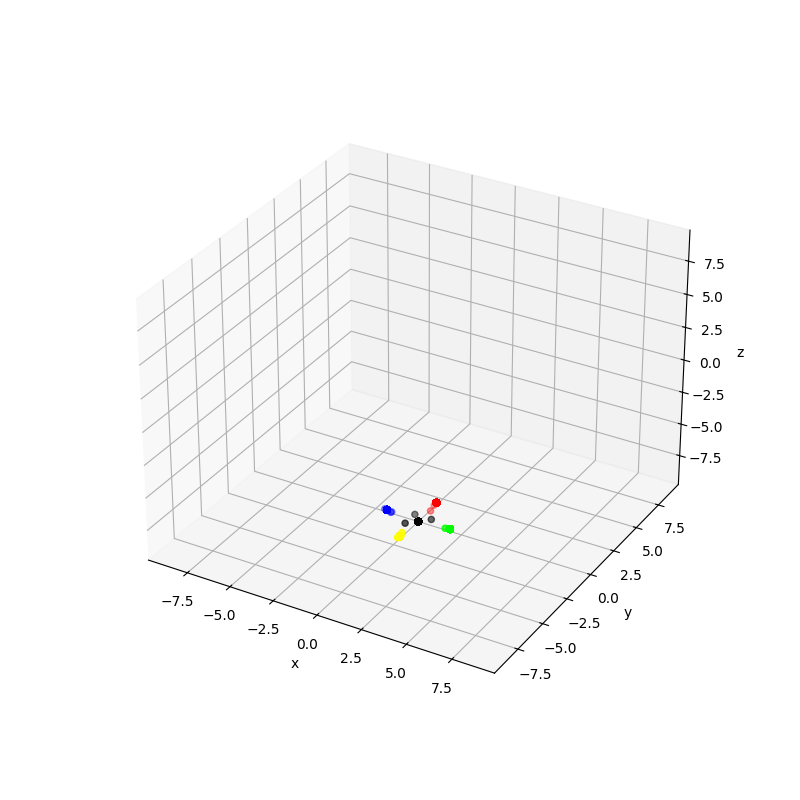

In [11]:
# wld like to change it but this does do colour for now...
final_positions_array_cart = np.array(to_cartesian(r_const, final_positions_array[:,0], final_positions_array[:,1]))
clusters = kmeans2(final_positions_array_cart.T, k=equilibria_regions)
groups = clusters[1]
## end

xs, ys, zs = to_cartesian(r_const, final_positions_array[:, 0], final_positions_array[:, 1])

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
clist = [col_map(x) for x in groups]
ax.scatter3D(xs, ys, zs, c=clist)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

L = r_const
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_zlim(-L,L)

(-9.80665, 9.80665)

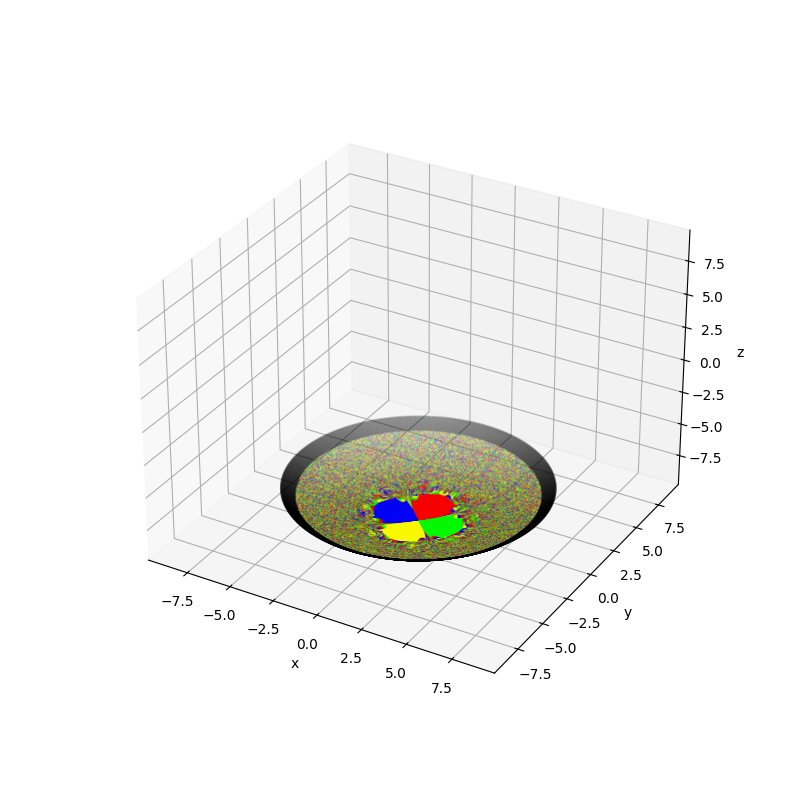

In [17]:
sphere_xs, sphere_ys, sphere_zs = to_cartesian(r_const, starting_θ_φ_pairs[:,0], starting_θ_φ_pairs[:,1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(sphere_xs, sphere_ys, sphere_zs, c=clist, s=0.01)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

L = r_const
ax.set_xlim(-L,L)
ax.set_ylim(-L,L)
ax.set_zlim(-L,L)



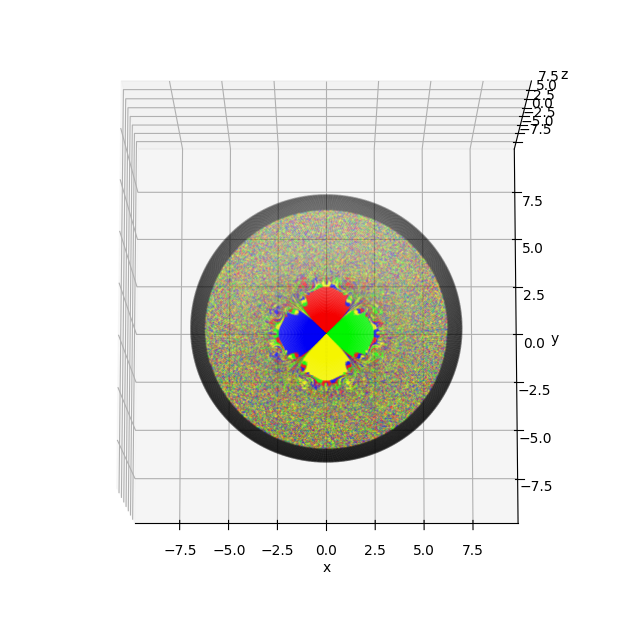

In [39]:
ax.view_init(elev=80, azim=270, roll=0)
fig